In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report
)

import statsmodels.api as ms

In [3]:
data = pd.read_csv('purchasing_behaviour_noisy.csv')
data.head(20)

,Purchasing behaviour,Gender,Age,Time spent in online shop
0,Buy now,female,22,40
1,Buy now,female,25,23
2,Buy now,male,18,12
3,Buy now,male,45,28
4,Buy now,female,12,43
5,Buy now,male,43,23
6,Buy now,male,23,55
7,Buy now,male,33,34
8,Buy later,female,27,28
9,Buy later,female,27,15


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674 entries, 0 to 673
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Purchasing behaviour       555 non-null    object
 1   Gender                     512 non-null    object
 2   Age                        641 non-null    object
 3   Time spent in online shop  628 non-null    object
dtypes: object(4)
memory usage: 21.2+ KB


In [5]:
data.describe(include= 'all')

,Purchasing behaviour,Gender,Age,Time spent in online shop
count,555,512,641,628
unique,5,3,101,135
top,Don't buy anything,male,18,76
freq,123,187,17,16


In [6]:
data.describe()

,Purchasing behaviour,Gender,Age,Time spent in online shop
count,555,512,641,628
unique,5,3,101,135
top,Don't buy anything,male,18,76
freq,123,187,17,16


In [7]:
data.shape

(674, 4)

In [8]:
data.isnull().sum()

Purchasing behaviour         119
Gender                       162
Age                           33
Time spent in online shop     46
dtype: int64

In [9]:
data.nunique()

Purchasing behaviour           5
Gender                         3
Age                          101
Time spent in online shop    135
dtype: int64

In [10]:
print(data['Purchasing behaviour'].value_counts(dropna=False))

Purchasing behaviour
Don't buy anything    123
NaN                   119
Buy now               117
Buy now!!             114
Buy later             113
                       88
Name: count, dtype: int64


## Removing Noise From Data one by one

### 2 — Normalize column names & keep a snapshot

In [11]:
data.columns = data.columns.str.strip().str.lower().str.replace(' ','_')
data_before = data.copy

In [12]:
data.head()

,purchasing_behaviour,gender,age,time_spent_in_online_shop
0,Buy now,female,22,40
1,Buy now,female,25,23
2,Buy now,male,18,12
3,Buy now,male,45,28
4,Buy now,female,12,43


### 3 — Clean categorical text (strip, lowercase, convert blanks to NaN)

In [13]:
def clean_text(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip().lower()
    
    if s in ['', 'nan', 'none', 'unknown']:
        return np.nan
    
    # normalize common noisy forms
    s = s.replace('buy now!!', 'buy now')
    s = s.replace('buynow', 'buy now')
    s = s.replace("don't", "don't")
    return s

data['purchasing_behaviour'] = data['purchasing_behaviour'].apply(clean_text)

data['gender'] = data['gender'].apply(lambda x: clean_text(x))
print(data['purchasing_behaviour'].value_counts(dropna = False))
print(data['gender'].value_counts(dropna = False))

purchasing_behaviour
buy now               231
NaN                   207
don't buy anything    123
buy later             113
Name: count, dtype: int64
gender
NaN       326
male      187
female    161
Name: count, dtype: int64


### 4 — Convert numeric columns to numeric (coerce invalid → NaN)

In [14]:
data['age'] = pd.to_numeric(data['age'], errors='coerce')
data['time_spent_in_online_shop'] = pd.to_numeric(data['time_spent_in_online_shop'], errors='coerce')

print(data[['age', 'time_spent_in_online_shop']].describe())

              age  time_spent_in_online_shop
count  631.000000                 621.000000
mean    50.748019                  78.737520
std     25.558241                 127.942378
min     -5.000000                   5.000000
25%     32.000000                  34.000000
50%     49.000000                  62.000000
75%     70.000000                  91.000000
max    150.000000                 999.000000


In [15]:
print(data[['age', 'time_spent_in_online_shop']].isnull().sum())

age                          43
time_spent_in_online_shop    53
dtype: int64


### 5 — Handle clearly invalid numeric ranges

In [16]:
# invalidate impossible ages and negative times
data.loc[(data['age'] < 12) | (data['age'] > 100), 'age'] = np.nan
data.loc[data['time_spent_in_online_shop'] < 0, 'time_spent_in_online_shop'] = np.nan

# inspect rows with extreme values
display(data.loc[data['time_spent_in_online_shop'] > 500].head())


,purchasing_behaviour,gender,age,time_spent_in_online_shop
35,buy now,male,71.0,999.0
105,buy now,NaN,NaN,999.0
310,buy later,male,82.0,999.0
346,don't buy anything,NaN,77.0,999.0
370,buy now,NaN,56.0,999.0


### 6 -- Duplicates

In [17]:
print("rows before deleteing dup.: ", len(data))

dups = data.duplicated(keep=False).sum()
print('total duplicated rows (any duplicate): ', dups)
data = data.drop_duplicates()

print("rows after dedup: ", len(data))

rows before deleteing dup.:  674
total duplicated rows (any duplicate):  110
rows after dedup:  618


Good question 🙂 — let’s go step by step.

---

### 1. What is **Winsorizing**?

* Winsorizing is a way to **handle extreme values (outliers)** without deleting rows.
* Instead of dropping them, you **“cap”** the values at a chosen percentile.

👉 Example: if you Winsorize at the 5th and 95th percentiles:

* Any value **below the 5th percentile** is replaced with the 5th percentile value.
* Any value **above the 95th percentile** is replaced with the 95th percentile value.

This keeps the dataset size the same but reduces the effect of outliers on models.

---

### 2. Small numeric example

Suppose you have ages:

```
[18, 22, 24, 25, 27, 29, 30, 31, 35, 120]
```

Clearly, `120` looks like an outlier.

* **Without Winsorize**:
  Mean age = \~36.1 (skewed upward by the outlier).

* **Winsorize at 5% and 95%**:

  * 5th percentile ≈ 19
  * 95th percentile ≈ 35
    Replace:

  ```
  [18 → 19, 22, 24, 25, 27, 29, 30, 31, 35, 120 → 35]
  ```

  New dataset:

  ```
  [19, 22, 24, 25, 27, 29, 30, 31, 35, 35]
  ```

  Mean age ≈ 27.7 (much closer to the real “center” of ages).

---

### 3. Pandas Example

```python
import pandas as pd

data = pd.Series([18, 22, 24, 25, 27, 29, 30, 31, 35, 120])

# calculate percentiles
low = data.quantile(0.05)  # 5th percentile
high = data.quantile(0.95) # 95th percentile

# winsorize using clip
winsorized = data.clip(lower=low, upper=high)

print("Original:", list(data))
print("Winsorized:", list(winsorized))
```

Output:

```
Original:   [18, 22, 24, 25, 27, 29, 30, 31, 35, 120]
Winsorized: [19, 22, 24, 25, 27, 29, 30, 31, 35, 35]
```

---

### 4. When to use Winsorizing

* ✔️ When you don’t want to **drop rows** (e.g., small datasets).
* ✔️ When extreme values are likely **measurement errors** or not relevant.
* ❌ If outliers are **real and meaningful** (like “time spent = 300 minutes” in an online shop for a very engaged user), you might not want to Winsorize — you’d lose useful info.

---

🔍 Quick check for you:
Imagine you have this series of times spent in an online shop:

```
[10, 12, 15, 20, 22, 30, 35, 40, 999]
```

👉 If we Winsorize at 5% and 95%, what will the **999** turn into?
(Think: what’s the 95th percentile here?)


### 7 — Outlier handling (IQR or clipping)

Two approaches: remove extreme outliers or winsorize/clip to extreme percentiles. Example IQR removal (drop rows outside 1.5*IQR) or clipping at 1st/99th percentile.

IQR-based removal:
```
for col in ['age','time_spent_in_online_shop']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    # keep rows where value is NaN (we'll impute later) or within bounds
    df = df[df[col].isna() | ((df[col] >= lower) & (df[col] <= upper))]

```
Winsorize (clip at 1% and 99%):
```
for col in ['age','time_spent_in_online_shop']:
    low = df[col].quantile(0.01)
    high = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=low, upper=high)
```

Which to use: clipping keeps rows but reduces influence of extremes; removal discards rows (use carefully if little data).

In [18]:
for col in ['age', 'time_spent_in_online_shop']:
    low = data[col].quantile(0.01)
    high = data[col].quantile(0.99)
    data[col] = data[col].clip(lower = low, upper = high)

/tmp/ipykernel_8671/4109386106.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].clip(lower = low, upper = high)
/tmp/ipykernel_8671/4109386106.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].clip(lower = low, upper = high)


### 8 — Missing value strategy (drop vs impute)

In [19]:
# drop rows missing the target
data = data[data['purchasing_behaviour'].notna()].copy()

# simple imputation using pandas
data['age'].fillna(data['age'].median(), inplace=True)
data['time_spent_in_online_shop'].fillna(data['time_spent_in_online_shop'].median(), inplace=True)
data['gender'].fillna(data['gender'].mode().iloc[0], inplace=True)


/tmp/ipykernel_8671/2571708072.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['age'].fillna(data['age'].median(), inplace=True)
/tmp/ipykernel_8671/2571708072.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

### 9 — Encode categoricals for modeling

Decide the target. For a binary logistic regression example, map buy now → 1, others → 0.

In [21]:
# Create Binary Target
data['target_buy_now'] = (data['purchasing_behaviour'] == 'buy now').astype(int)

# encode gender
data['gender_code'] = data['gender'].map({'male':0, 'female':1})


## Now Perform Logistice Regression

In [22]:
# final features
features = ['gender_code','age', 'time_spent_in_online_shop']
x = data[features]
y = data['target_buy_now']

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

In [25]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))
print("accuracy:", accuracy_score(y_test, y_pred))
print("roc_auc:", roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

           0       0.52      0.71      0.60        45
           1       0.48      0.29      0.36        41

    accuracy                           0.51        86
   macro avg       0.50      0.50      0.48        86
weighted avg       0.50      0.51      0.49        86

accuracy: 0.5116279069767442
roc_auc: 0.45772357723577234


In [27]:
data.to_csv("purchasing_behaviour_cleaned.csv", index=False)


In [33]:
# Step 2: convert probabilities to binary predictions
y_pred = (y_pred >= 0.5).astype(int)

# Step 3: evaluate
print("\n=== Evaluation metrics on test set ===")
print("accuracy:", accuracy_score(y_test, y_pred))
print("precision:", precision_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))
print("f1:", f1_score(y_test, y_pred))
print("roc_auc:", roc_auc_score(y_test, y_pred))

print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))


=== Evaluation metrics on test set ===
accuracy: 0.5116279069767442
precision: 0.48
recall: 0.2926829268292683
f1: 0.36363636363636365
roc_auc: 0.5018970189701897

Confusion matrix:
 [[32 13]
 [29 12]]

Classification report:
               precision    recall  f1-score   support

           0       0.52      0.71      0.60        45
           1       0.48      0.29      0.36        41

    accuracy                           0.51        86
   macro avg       0.50      0.50      0.48        86
weighted avg       0.50      0.51      0.49        86



<Axes: xlabel='Predicted', ylabel='Actual'>

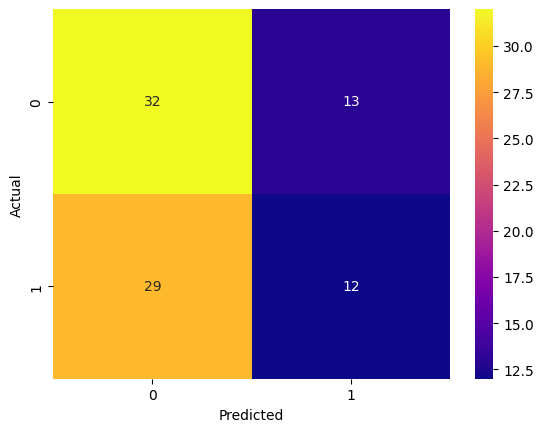

In [35]:
conf_mat = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_mat, annot=True, cmap='plasma')

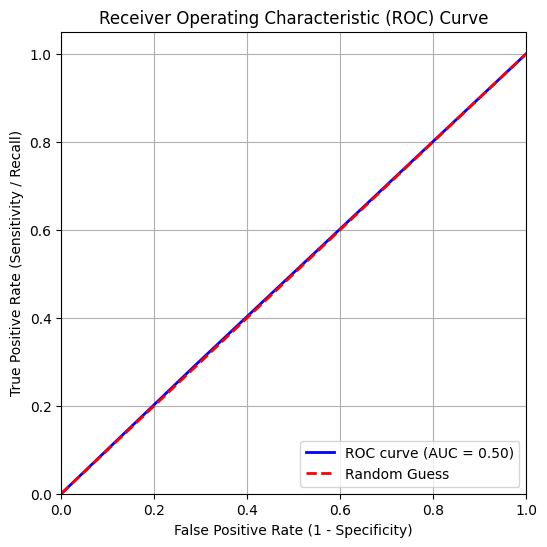

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 1. Get false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# 2. Compute Area Under Curve (AUC)
roc_auc = auc(fpr, tpr)

# 3. Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--", label="Random Guess")

# 4. Format the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity / Recall)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

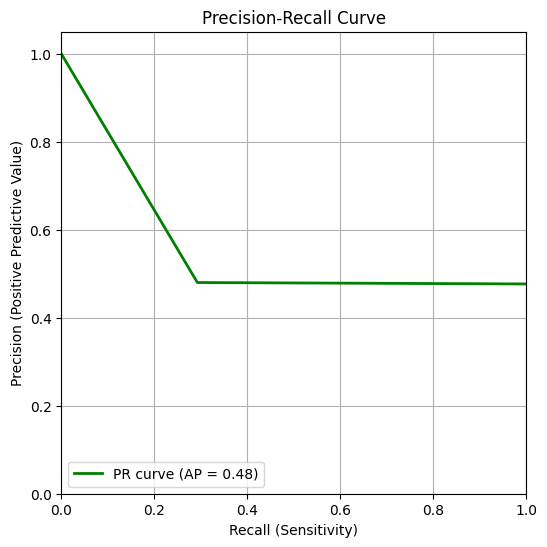

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# 1. Get precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# 2. Compute Average Precision (AP)
ap = average_precision_score(y_test, y_pred)

# 3. Plot Precision-Recall curve
plt.figure(figsize=(6,6))
plt.plot(recall, precision, color="green", lw=2, label=f"PR curve (AP = {ap:.2f})")

# 4. Format the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision (Positive Predictive Value)")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()
